# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.matlib
import mat73
import colorcet as cc
import seaborn as sns
import os
import xarray as xr
import pysindy as ps
import pandas as pd
from pandas import Series, DataFrame
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

from scipy import signal, linalg, stats, io
from scipy.ndimage import gaussian_filter1d, median_filter as medfilt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter as medfilt

from utils import tic, toc

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession, removed_unused_stimulus_presentation_columns
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

from ripple_detection import Kay_ripple_detector

%matplotlib inline

In [2]:
rootdir = '/home/ryanr/Allen'
outdir = '/home/ryanr/Allen/arousal_final/Allen'

## Define some functions for data processing and computing observables

In [3]:
## borrowing this logic from https://github.com/psu-mcnl/Neural-Cascade
class DataContainer:
    def __init__(self):
        pass

class StimulusSpecificData:
    def __init__(self, name):
        self.stimName = name
        
def process_spont(session_data, use_all_neurons=True):
    
    spont_data = StimulusSpecificData('spontaneous')

    """ spontaneous stimulus info """
    stimTable = session_data.get_stimulus_table('spontaneous')
    spont_data.stimTable = stimTable
    spont_data.stimID = stimTable.index[-2]
    spont_data.tstart = stimTable['start_time'].values[-2]
    spont_data.tstop = stimTable['stop_time'].values[-2]
    spont_data.tdur = stimTable['duration'].values[-2]
    
    """ process pupil data """
    pupil = session_data.get_pupil_data()
    stim_pupil = pupil[(pupil.index>spont_data.tstart) & (pupil.index<spont_data.tstop)]
    stim_pupil.index = stim_pupil.index - spont_data.tstart

    pupil_size = stim_pupil.loc[:, ['pupil_height', 'pupil_width']].mean(axis=1).values
    pupil_time = stim_pupil.index.values

    spont_data.pupil_data = stim_pupil
    spont_data.pupil_size = pupil_size
    spont_data.pupil_time = pupil_time

    """ process running data """
    running = session_data.running_speed
    stim_running = running[(running['start_time']>spont_data.tstart) & (running['end_time']<spont_data.tstop)]
    running_speed = stim_running.velocity.values
    running_time = stim_running.iloc[:,0:2].mean(axis=1) - spont_data.tstart
    running_speed[running_speed < -90 * running_speed.std()] = 0
    spont_data.running_speed = running_speed
    spont_data.running_time = running_time.values
    
    """ process spike data """
    unitid = session_data.units.index
    tstep = 1.2
    spont_data.tbins = np.arange(0,int(spont_data.tdur)+1,tstep)
    spont_data.spikect = session_data.presentationwise_spike_counts(spont_data.tbins, spont_data.stimID, unitid).squeeze()
    spont_data.rates = signal.resample(spont_data.spikect, len(spont_data.pupil_time))

    return spont_data

In [4]:
def process_lfp(session_data, spont_data):

    lfp = DataContainer()

    probesid = session_data.probes.index.values
    sr = session_data.probes.lfp_sampling_rate.values[0]    

    lfp_time = None
    t_pad = 0

    spont_lfpCA1 = list()
    spont_lfpVIS = list()

    for pid in probesid:
        print('processing lfp data for probe-{:d}'.format(pid))
        try:
            spont_lfp = session_data.get_lfp(pid).sel(time=slice(spont_data.tstart-t_pad, spont_data.tstop+t_pad))
        except ValueError:
            print('Probe does not exist')
            continue
        
        spont_lfp = spont_lfp.assign_coords(time = spont_lfp.time - spont_data.tstart)

        spont_lfp = spont_lfp.interpolate_na(dim="time",method="linear")
        
        chnid = spont_lfp.channel.values
        try:
            chnloc = channels.loc[chnid, 'ecephys_structure_acronym']
        except:
            print("missing channel!")
            continue
            
        spont_lfp = spont_lfp.drop_sel(channel=chnid[np.where(chnloc.str.match('NaN'))])
        chnid = spont_lfp.channel.values
        chnloc = channels.loc[chnid, 'ecephys_structure_acronym']
        
        if lfp_time is not None:
            intp = interp1d(spont_lfp.time.values.T, spont_lfp.values.T)
            sig_intp = intp(lfp_time.values).T
            spont_lfp = xr.DataArray(sig_intp, coords=[lfp_time, spont_lfp.channel])
        else:
            lfp_time = spont_lfp.time
            t_pad = 1
        
        spont_lfpCA1.append(spont_lfp.sel(channel=chnid[np.where(chnloc.str.match('CA1'))]))
        spont_lfpVIS.append(spont_lfp.sel(channel=chnid[np.where(chnloc.str.match('VIS'))]))

    spont_lfpCA1 = xr.concat(spont_lfpCA1, dim="channel")
    spont_lfpVIS = xr.concat(spont_lfpVIS, dim="channel")

    lfp.probesid = probesid
    lfp.sr = sr

    CA1chn = spont_lfpCA1.channel.values
    CA1time = lfp_time.values
    lfp.CA1chn = CA1chn
    lfp.CA1time = CA1time

    lfp.spont_lfpVIS = spont_lfpVIS
    lfp.spont_lfpCA1 = spont_lfpCA1
    
    speed = np.ones_like(lfp.CA1time)
    ripple_times = Kay_ripple_detector(lfp.CA1time, spont_lfpCA1.values.copy(), speed, lfp.sr)
    
    ripples = ripple_times.end_time

    # 5 s window
    ripple_time = np.linspace(lfp.CA1time[0],lfp.CA1time[-1],int(np.ceil(5*(lfp.CA1time[-1]-lfp.CA1time[0]))))
    ripple_rate = np.empty(ripple_time.size)
    for i in range(ripple_rate.size-1):
        ripple_rate[i] = len(ripples[(ripples>ripple_time[i])&(ripples<ripple_time[i+1])])

    lfp.ripple_rate = ripple_rate
    lfp.ripple_time = ripple_time
    
    return lfp

In [5]:
def compute_obs(spont_data, lfp, window_time=.5, dt=.1, medfilt=21, normalize=True):

    nperseg = int(window_time*lfp.sr/6)
    noverlap = int( (1-dt/window_time) * nperseg)

    sos = signal.butter(4, 100, btype = 'lowpass', output = 'sos', fs = lfp.sr)

    d = lfp.spont_lfpVIS.values
    d = signal.sosfiltfilt(sos, d)
    d = signal.decimate(d,6,axis=0)

    f_spec, t_spec, spec = signal.spectrogram(d, fs=lfp.sr/6, nperseg=nperseg, noverlap=noverlap, axis=0)
    #t_spec = t_spec + t[0]

    spec = np.nanmean(spec,axis=1)

    fmax = 100
    f_new = f_spec[f_spec<fmax]
    spec_new = spec[f_spec<fmax,:].T # can visualize spec_new with t_spec, f_new as x and y 

    ## Delta, Alpha, Gamma
    delta_mean = np.nansum(spec_new[:,(f_new>.5) & (f_new<4)],axis=1)
    alpha_mean = np.nansum(spec_new[:,(f_new>3) & (f_new<6)],axis=1)
    gamma_mean = np.nansum(spec_new[:,(f_new>40) & (f_new<100)],axis=1)

    if normalize:
        delta_mean = delta_mean / np.nansum(spec_new[:,(f_new>.5) & (f_new<100)],axis=1)
        alpha_mean = alpha_mean / np.nansum(spec_new[:,(f_new>.5) & (f_new<100)],axis=1) 
        gamma_mean = gamma_mean / np.nansum(spec_new[:,(f_new>.5) & (f_new<100)],axis=1)
    
    if medfilt:
        delta_mean = signal.medfilt(delta_mean,medfilt)
        alpha_mean = signal.medfilt(alpha_mean,medfilt)
        gamma_mean = signal.medfilt(gamma_mean,medfilt)

    delta_mean = signal.resample(delta_mean,len(spont_data.pupil_size))
    alpha_mean = signal.resample(alpha_mean,len(spont_data.pupil_size))
    gamma_mean = signal.resample(gamma_mean,len(spont_data.pupil_size))
    
    ####################
    
    sos = signal.butter(4, 100, btype = 'lowpass', output = 'sos', fs = lfp.sr)

    d = lfp.spont_lfpCA1.values
    d = signal.sosfiltfilt(sos, d)
    d = signal.decimate(d,6,axis=0)

    f_spec, t_spec, spec = signal.spectrogram(d, fs=lfp.sr/6, nperseg=nperseg, noverlap=noverlap, axis=0)
    #t_spec = t_spec + t[0]

    spec = np.nanmean(spec,axis=1)

    fmax = 100
    f_new = f_spec[f_spec<fmax]
    spec_new = spec[f_spec<fmax,:].T
    
    ## Hippocampal Delta, Theta
    hc_delta_mean = np.nansum(spec_new[:,(f_new>.5) & (f_new<4)],axis=1)
    hc_theta_mean = np.nansum(spec_new[:,(f_new>5) & (f_new<9)],axis=1)
    
    if normalize:
        hc_delta_mean = hc_delta_mean / np.nansum(spec_new[:,(f_new>.5) & (f_new<100)],axis=1)
        hc_theta_mean = hc_theta_mean / np.nansum(spec_new[:,(f_new>.5) & (f_new<100)],axis=1) 
    
    if medfilt:
        hc_delta_mean = signal.medfilt(hc_delta_mean,medfilt)
        hc_theta_mean = signal.medfilt(hc_theta_mean,medfilt)

    hc_delta_mean = signal.resample(hc_delta_mean,len(spont_data.pupil_size))
    hc_theta_mean = signal.resample(hc_theta_mean,len(spont_data.pupil_size))    

    ## SWRs
    ripple_rate = gaussian_filter1d(lfp.ripple_rate,5)
    ripple_rate = signal.resample(ripple_rate, len(spont_data.pupil_size))

    ## run_speed
    run_speed = signal.resample(np.convolve(spont_data.running_speed,np.ones(1,dtype=int),'same'), len(spont_data.pupil_size))
    
    ## mean firing rate
    mean_rate = np.mean(spont_data.rates,axis=1)

    ## store
    obs = np.zeros([len(spont_data.pupil_size),8])
    x = Series(spont_data.pupil_size).interpolate().values
    x = signal.medfilt(x,11)
    x = x / np.max(x)
    pupil_clean = signal.detrend(x)
    obs[:,0] = pupil_clean
    obs[:,1] = run_speed
    obs[:,2] = hc_theta_mean/hc_delta_mean
    obs[:,3] = ripple_rate
    obs[:,4] = delta_mean
    obs[:,5] = alpha_mean
    obs[:,6] = gamma_mean
    obs[:,7] = mean_rate
        
    return obs

In [6]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join("../../ecephys_cache_dir/", "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
channels = cache.get_channels()
session_IDs = sessions[sessions['session_type']=='functional_connectivity'].index.values

print(session_IDs)

bad_session_IDs = []
missing_pupil = [768515987,840012044]
missing_lfp = [839557629]
bad_pupil = [835479236,839068429]
bad_session_IDs.extend(missing_pupil)
bad_session_IDs.extend(missing_lfp)
bad_session_IDs.extend(bad_pupil)

mask = ~np.in1d(session_IDs, bad_session_IDs)
session_IDs = session_IDs[mask]

[766640955 767871931 768515987 771160300 771990200 774875821 778240327
 778998620 779839471 781842082 786091066 787025148 789848216 793224716
 794812542 816200189 819186360 819701982 821695405 829720705 831882777
 835479236 839068429 839557629 840012044 847657808]


## Compute and save observables for each session

In [7]:
for session_id in session_IDs:

    session = cache.get_session_data(session_id)  
    
    print('Processing session ' + str(session_id) + '...')

    print('Processing spontaneous data')
    tic()
    spont_data = process_spont(session)
    toc()
    
    print('Processing LFP')
    tic()
    lfp = process_lfp(session,spont_data)
    toc()
    
    print('Computing observables')
    tic()
    obs = compute_obs(spont_data, lfp, window_time=.5, dt=.1, medfilt=0)
    np.save(rootdir + '/ecephys_cache_dir/' + str(session_id) + '_obs_spectrogram_wt0p5_dt0p1_medfilt0', obs)
    toc()
    
    print('Finished processing session ' + str(session_id))

/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 766640955...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 38.3498170375824 seconds.
Processing LFP
processing lfp data for probe-773592315
processing lfp data for probe-773592318
missing channel!
processing lfp data for probe-773592320
processing lfp data for probe-773592324
processing lfp data for probe-773592328
missing channel!
processing lfp data for probe-773592330
Elapsed time is 241.2029914855957 seconds.
Computing observables
Elapsed time is 26.154097318649292 seconds.
Finished processing session 766640955


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 767871931...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 38.00693726539612 seconds.
Processing LFP
processing lfp data for probe-773462985
processing lfp data for probe-773462990
missing channel!
processing lfp data for probe-773462993
processing lfp data for probe-773462995
processing lfp data for probe-773462997
missing channel!
processing lfp data for probe-773462999
Elapsed time is 272.6226875782013 seconds.
Computing observables
Elapsed time is 23.143313884735107 seconds.
Finished processing session 767871931


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 771160300...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 39.169517517089844 seconds.
Processing LFP
processing lfp data for probe-773621937
processing lfp data for probe-773621939
missing channel!
processing lfp data for probe-773621942
processing lfp data for probe-773621945
processing lfp data for probe-773621948
processing lfp data for probe-773621950
Elapsed time is 283.3782744407654 seconds.
Computing observables
Elapsed time is 34.70555377006531 seconds.
Finished processing session 771160300


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 771990200...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 38.10893940925598 seconds.
Processing LFP
processing lfp data for probe-773654723
processing lfp data for probe-773654726
missing channel!
processing lfp data for probe-773654728
processing lfp data for probe-773654730
processing lfp data for probe-773654732
processing lfp data for probe-773654734
missing channel!
Elapsed time is 237.62711238861084 seconds.
Computing observables
Elapsed time is 24.490381717681885 seconds.
Finished processing session 771990200


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 774875821...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 36.946184158325195 seconds.
Processing LFP
processing lfp data for probe-792602650
processing lfp data for probe-792602652
missing channel!
processing lfp data for probe-792602654
processing lfp data for probe-792602656
processing lfp data for probe-792602658
processing lfp data for probe-792602660
Elapsed time is 244.75091409683228 seconds.
Computing observables
Elapsed time is 32.11322045326233 seconds.
Finished processing session 774875821


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 778240327...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 37.433202028274536 seconds.
Processing LFP
processing lfp data for probe-792607545
processing lfp data for probe-792607547
missing channel!
processing lfp data for probe-792607549
processing lfp data for probe-792607553
processing lfp data for probe-792607557
processing lfp data for probe-792607559
Elapsed time is 279.05446338653564 seconds.
Computing observables
Elapsed time is 33.753700494766235 seconds.
Finished processing session 778240327


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 778998620...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 36.43026685714722 seconds.
Processing LFP
processing lfp data for probe-792626841
processing lfp data for probe-792626844
missing channel!
processing lfp data for probe-792626847
processing lfp data for probe-792626851
processing lfp data for probe-792626853
processing lfp data for probe-792626855
Elapsed time is 270.939040184021 seconds.
Computing observables
Elapsed time is 31.37503147125244 seconds.
Finished processing session 778998620


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 779839471...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 37.976489305496216 seconds.
Processing LFP
processing lfp data for probe-792645490
processing lfp data for probe-792645493
missing channel!
processing lfp data for probe-792645497
processing lfp data for probe-792645499
processing lfp data for probe-792645501
processing lfp data for probe-792645504
missing channel!
Elapsed time is 240.23381423950195 seconds.
Computing observables
Elapsed time is 26.1080424785614 seconds.
Finished processing session 779839471


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 781842082...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 38.160754680633545 seconds.
Processing LFP
processing lfp data for probe-792586876
processing lfp data for probe-792586879
missing channel!
processing lfp data for probe-792586881
processing lfp data for probe-792586883
processing lfp data for probe-792586887
missing channel!
processing lfp data for probe-792586891
Elapsed time is 240.013676404953 seconds.
Computing observables
Elapsed time is 22.98030161857605 seconds.
Finished processing session 781842082


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 786091066...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 37.03244876861572 seconds.
Processing LFP
processing lfp data for probe-792623916
processing lfp data for probe-792623919
missing channel!
processing lfp data for probe-792623921
processing lfp data for probe-792623925
missing channel!
processing lfp data for probe-792623928
missing channel!
processing lfp data for probe-792623931
Elapsed time is 190.40954899787903 seconds.
Computing observables
Elapsed time is 16.905435800552368 seconds.
Finished processing session 786091066


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 787025148...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 38.34780836105347 seconds.
Processing LFP
processing lfp data for probe-792586836
processing lfp data for probe-792586840
missing channel!
processing lfp data for probe-792586842
processing lfp data for probe-792586845
processing lfp data for probe-792586848
missing channel!
processing lfp data for probe-792586852
Elapsed time is 254.43338418006897 seconds.
Computing observables
Elapsed time is 24.497434616088867 seconds.
Finished processing session 787025148


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 789848216...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 34.77083206176758 seconds.
Processing LFP
processing lfp data for probe-805002027
processing lfp data for probe-805002029
missing channel!
processing lfp data for probe-805002031
processing lfp data for probe-805002033
processing lfp data for probe-805002035
missing channel!
processing lfp data for probe-805002037
Elapsed time is 251.71582126617432 seconds.
Computing observables
Elapsed time is 27.331371784210205 seconds.
Finished processing session 789848216


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 793224716...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 87.29489398002625 seconds.
Processing LFP
processing lfp data for probe-805124802
processing lfp data for probe-805124804
missing channel!
processing lfp data for probe-805124806
processing lfp data for probe-805124809
processing lfp data for probe-805124812
missing channel!
processing lfp data for probe-805124815
Elapsed time is 235.0215277671814 seconds.
Computing observables
Elapsed time is 21.48611617088318 seconds.
Finished processing session 793224716


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 794812542...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 38.31858706474304 seconds.
Processing LFP
processing lfp data for probe-810758777
processing lfp data for probe-810758779
missing channel!
processing lfp data for probe-810758781
processing lfp data for probe-810758783
processing lfp data for probe-810758785
processing lfp data for probe-810758787
missing channel!
Elapsed time is 239.77529644966125 seconds.
Computing observables
Elapsed time is 24.142852544784546 seconds.
Finished processing session 794812542


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 816200189...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 35.55977201461792 seconds.
Processing LFP
processing lfp data for probe-836943713
processing lfp data for probe-836943715
processing lfp data for probe-836943717
processing lfp data for probe-836943719
missing channel!
processing lfp data for probe-836943721
Elapsed time is 229.5054738521576 seconds.
Computing observables
Elapsed time is 22.725754022598267 seconds.
Finished processing session 816200189


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 819186360...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 35.73403716087341 seconds.
Processing LFP
processing lfp data for probe-820311754
missing channel!
processing lfp data for probe-820311756
missing channel!
processing lfp data for probe-820311760
missing channel!
processing lfp data for probe-820311762
processing lfp data for probe-820311764
Elapsed time is 178.778240442276 seconds.
Computing observables
Elapsed time is 14.874998092651367 seconds.
Finished processing session 819186360


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 819701982...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 35.644033432006836 seconds.
Processing LFP
processing lfp data for probe-836962814
processing lfp data for probe-836962816
processing lfp data for probe-836962820
missing channel!
processing lfp data for probe-836962822
processing lfp data for probe-836962824
Elapsed time is 217.6158266067505 seconds.
Computing observables
Elapsed time is 24.45896053314209 seconds.
Finished processing session 819701982


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 821695405...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 36.015763998031616 seconds.
Processing LFP
processing lfp data for probe-822645893
processing lfp data for probe-822645895
processing lfp data for probe-822645897
missing channel!
processing lfp data for probe-822645899
missing channel!
processing lfp data for probe-822645901
Elapsed time is 180.5277750492096 seconds.
Computing observables
Elapsed time is 17.314308643341064 seconds.
Finished processing session 821695405


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 829720705...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 35.505472898483276 seconds.
Processing LFP
processing lfp data for probe-832129149
missing channel!
processing lfp data for probe-832129154
processing lfp data for probe-832129157
missing channel!
processing lfp data for probe-832129159
processing lfp data for probe-832129161
Elapsed time is 174.6418857574463 seconds.
Computing observables
Elapsed time is 17.96936321258545 seconds.
Finished processing session 829720705


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 831882777...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 36.42828631401062 seconds.
Processing LFP
processing lfp data for probe-832810573
processing lfp data for probe-832810576
processing lfp data for probe-832810578
processing lfp data for probe-832810580
missing channel!
processing lfp data for probe-832810582
processing lfp data for probe-832810584
Probe does not exist
Elapsed time is 194.2458622455597 seconds.
Computing observables
Elapsed time is 20.665181636810303 seconds.
Finished processing session 831882777


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Processing session 847657808...
Processing spontaneous data


/home/ryanr/.local/lib/python3.8/site-packages/hdmf/utils.py:577: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)


Elapsed time is 40.504844188690186 seconds.
Processing LFP
processing lfp data for probe-848037568
processing lfp data for probe-848037570
processing lfp data for probe-848037572
processing lfp data for probe-848037574
processing lfp data for probe-848037576
processing lfp data for probe-848037578
Elapsed time is 272.6856269836426 seconds.
Computing observables
Elapsed time is 32.66610622406006 seconds.
Finished processing session 847657808


### Let's quickly visualize some observables from one mouse

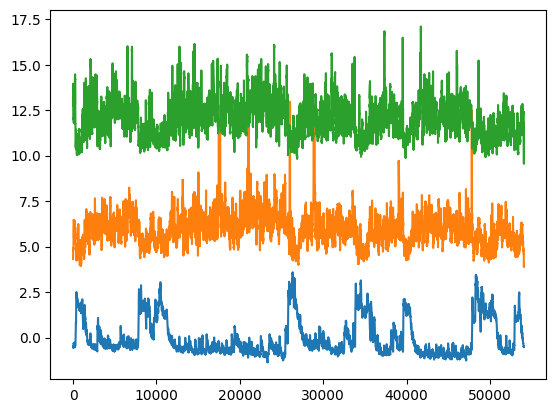

In [8]:
obs = np.load(rootdir + '/ecephys_cache_dir/' + str(session_id) + '_obs_spectrogram_wt0p5_dt0p1_medfilt21.npy')

plt.figure()

plt.plot(stats.zscore(obs[:,0])) # pupil
plt.plot(6+stats.zscore(obs[:,4])) # delta BLP
plt.plot(12+stats.zscore(obs[:,5])) # alpha BLP
    
plt.show()